<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Earthquake physics</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)"> Dynamic Rupture in 1D </div>
        </div>
    </div>
</div>

##### Authors:
* Mitchell Williams
* Kenneth Duru

---

## Description

### Background 

This notebook simulates  dynamic earthquake ruptures and elastic wave propagation in one space dimensions (1D). Spontaneously propagating shear ruptures on a frictional interface in an elastic solid is a useful idealization of natural earthquakes. The conditions relating slip-rate and fault strength are often expressed as nonlinear friction laws.

During an earthquake, two sides of the fault, initially held in contact by a high level of frictional resistance, slip suddenly when that resistance catastrophically decreases, generating strong ground shaking which is carried by seismic waves to remote areas, far away from fault zones

This notebook describes, and implements, a high order accurate finite difference method for enforcing nonlinear friction laws, in a consistent and provably stable manner, suitable for efficient explicit time integration and accurate propagation of seismic waves in heterogeneous media with free surface boundary conditions.
<br/><br/>

--------------------------------------------------------------------
### The elastic wave equation
--------------------------------------------------------------------
Consider two elastic solids separated by a fault at the interface $x = 0$. In each elastic solid, wave motion is described by the elastic wave equation, in velocity-stress formulation: 
<br/><br/> 
\begin{align}
{\rho} \frac{ \partial v}{\partial t} = \frac{ \partial \sigma}{\partial x},   {\quad}   \frac{1}{\mu} \frac{ \partial \sigma}{\partial t} = \frac{\partial v}{\partial x},
\end{align}
<br/> <br/>
 with particle velocity ${v}$, stress field ${\sigma }$, shear modulus $\mu$, and density ${\rho}$.
<br/><br/>

-----------------------------------------------------------------
 
Denoting the fields in the positive and the negative parts of the fault with the superscripts $\pm$, we introduce the jumps in particle velocities by $\lbrack{v}\rbrack = {v}^{+}-{v}^{-}$, and  the total traction by $\sigma = \sigma_{0} + \Delta{\sigma}$, where $\sigma_{0}$ is the initial background shear traction and $\Delta{\sigma}$ is the traction changes on the fault. The conditions on the fault connecting the two elastic solids are
<br/><br/> 
\begin{align}
\text{force balance}&: \quad \sigma^{+} = \sigma^{-} = \sigma, \\
\text{friction laws}&: \quad \sigma = \sigma_n\frac{f(V, \theta)}{V}\lbrack{v}\rbrack, \quad V = \left|\lbrack{v}\rbrack\right|.
\end{align}
<br/> <br/>
 Here $\sigma_n > 0$ is the compressive normal stress and $ f(V, \theta) \ge 0 $ is the nonlinear fricition coefficient relating to the fault's shear strength, $\tau = |\sigma| > 0$, and will be described  in more detail below.
<br/><br/>

-------------------------------------------------------------


### Friction laws

It is necessary to consider the role of friction in all of this because it modulates the stresses and slip speed as the separate sides of the fault slip past each other. The first thing to consider is that as the fault slips it experiences shear strength ${\tau}$ which is exerted by the normal stresses on the fault ${\sigma_n}$. The way these two variables are related is through the friction coefficient ${f}$: ${\quad} {\tau} = f \cdot {\sigma_n}$. 

 For the purposes of this notebook  we consider two widely used models of friction, *slip-weakening* and *rate-and-state*. <br/>


<p style="width:75%;float:right;padding-left:50px">
<img src=RS_graph.png>
<span style="font-size:smaller">
</span>
</p>
Figure source:
#### Slip Weakening Friction
Slip weakening friction describes a friction behavior in which friction coefficient weakens linearly with slip.  When the fault is at rest the friction coefficient is denoted by static friction coefficient ${f_s}$, when the fault is in motion the friction coefficient is denoted by the dynamic friction coefficient ${f_d}$. An earthquake begins when the load $\tau$ at a finite patch on the fault overcomes the peak frictional strength, $\tau \ge \tau_p$, ${\quad \tau_p = f_s \cdot \sigma_n}$.  As the earthquake continues the fault surfaces slide relative to each other  and the frictional coefficient evolves from linearly from static friction coefficient $f_s$  to the dynamic friction coefficient ${f_d}$. The fault is fully weakened when the slip reaches the critical slip ${D_c}$. This can be seen in the figure below which plots the friction coefficient as a function of slip.
 
![RS_graph.png](attachment:RS_graph.png)

#### Rate and State Friction

Rate and state friction is a constitutive law that was empirically found and is considered more realistic than slip weakening. It takes the form:  

\begin{align}
 &\tau = \sigma_n \cdot f(V, \theta), \quad f(V, \theta) = [ f_0 + a \cdot ln(\frac {V}{V_0}) + b \cdot ln( \frac{V_0 \theta}{D_c})], \\
  &\frac {d \theta}{dt} = G(V, \theta).
 \end{align}

In this equation ${V}$ is the current slip velocity and ${V_0}$ is a reference slip velocity while ${f_0}$ is the steady state friction coefficient at the reference velocity: ${f_{V= V_0}}$. There is the state variable ${\theta}$, and the state evolution law $G(V, \theta)$. We consider specifically the aging law: ${ G(V, \theta) = 1 - \frac {V\theta }{D_c}.\quad}$ At steady state the state variable is proportional to the critical distance divided by velocity ${ \theta_{ss} = \frac {D_c}{V}}$  <br/>

Here ${a}$ is the *direct effect* and is used to model how the system responds to velocity changes. ${b}$ is the *evolution effect* and describes the magnitude of the steady state friction.  ${D_c}$ is the critical distance and corresponds to the slip length over which the evolution of ${a \to b}$ occurs. The relationship of ${a}$ and ${b}$ to the slip weakening friction variables is as follows: ${\quad b = \frac {df_s}{d(ln(t))} \quad, \quad (a-b) = \frac {df_d}{d(ln(V))} \quad}$ where ${t}$ is the amount of time of contact without an earthquake. It is interesting to notice that there is a relationship between slip velocity ${V}$ and dynamic friction ${f_d}$ that depends on the difference ${(a-b)}$. If ${(a-b)>0}$ it shows that there is a velocity strengthening relationship ${\frac {df_d}{d(ln(V))} > 0}$. Any rupture that enters this region will arrest and is called a *stable* region. If ${(a-b)<0}$ it shows that there is a velocity weakening relationship ${\frac {df_d}{d(ln(V))} < 0}$, this is where earthquakes can nucleate and grow and is called *unstable*. On the border between *stable* and *unstable* regions is a zone of *conditional stability* where ruptures can sustain propagation while not growing or terminating. This notebook only exists in the unstable zone.

The equations are discretized using the SBP-SAT finite difference scheme. Time integration is performed using the classical fourth order accurate Runge-Kutta method. For more elaborate discussions, we refer the reader to the references and the  notebooks on the SBP-SAT method. A summary of the numerical implementations used in the this notebook is presentated in the flow-chart below.

<img src=1Dnotebook_flowchart.jpg>

### Putting it together

In the parameter window you can modulate the material properties, run time, domain size, and CFL criterion. In addition, you can choose rate and state friction or slip weakening friction, notice the differences that occur with this choice. In the Calculations and plotting cell the resulting on fault tractions and slip velocities are solved for in the time_integrator.elastic_RK4 function, which also calls on the other associated functions. The bottom cell contains 5 output plots of the rupture behavior.  




#### References 
Byerlee, J. “Friction of Rocks.” Rock Friction and Earthquake Prediction, vol. 116, 1978, pp. 615–626., doi:10.1007/978-3-0348-7182-2_4. <br/>
Duru, Kenneth, and Eric M. Dunham. “Dynamic Earthquake Rupture Simulations on Nonplanar Faults Embedded in 3D 
Geometrically Complex, <br/>${\quad}$ Heterogeneous Elastic Solids.” Journal of Computational Physics, vol. 305, 2016, pp. 185–207., doi: 10.1016/j.jcp.2015.10.0215<br/>
Gustafsson, Bertil. High Order Difference Methods for Time Dependent PDE. Springer, 2008.<br/>
Kozdon, J. E., E. M. Dunham, and J. Nordström (2012), Interaction of waves with frictional interfaces using summation-by-parts difference operators:<br/>${\quad}$  Weak enforcement of nonlinear boundary conditions, Journal of Scientific Computing, 50(2), 341-367, doi:10.1007/s10915-011-9485-3<br/>
Leeman, John. “Modeling Rate and State Friction with Python.” SciPy 2016. Austin, USA.<br/>
Scholz, Christopher H. “Earthquakes and Friction Laws.” Nature, vol. 391, no. 6662, 1998, pp. 37–42., doi:10.1038/34097.

### Exercises   

Explore the following questions by interacting with the variables in the parameter window. 


* **1)** Explore the differences between slip weakening and rate and state frictions. How does this alter the slip rate and Traction drop profiles? 



* **2)** How does altering the CFL change the model time? Does lowering it increase or decrease the amount of numerical artifacts? 


* ** 3)** Does changing the density alter the slip rate? 



* **4) **What do you notice when altering the order of accuracy in terms of computation time and accuracy of the model? Is the trade-off worth it for this model? 



* **5)** What is the relationship between fault slip and traction in both types of friction? 




In [1]:
# Import necessary routines

import numpy as np
import matplotlib.pyplot as plt
import time_integrator
import rate
import utils
import timeit

plt.switch_backend("nbagg")           # plots within this notebook

In [2]:
# Parameter cell
# All user defined parameters can be entered in this window. 

tend = 2.0            # final time
cfl = 0.5             # CFL number

L = 15.0              # length of the domain (km)
nx = 601              # grid points in x       
cs = 3.464            # shear wave velocity (km/s) (can be an array)                                                                                                             
rho = 2.6702          # density [g/cm^3]

iplot = 5             # snapshot frequency
order = 6             # order of accuracy

fric_law = 'SW'       #'SW = slip weakening', 'RS' = rate and state  



In [3]:
# Initialization cell 
# Do not alter
# spacing and material parameters

ny = nx                              # grid points in y                                                                                                                       
dx = L/(nx-1)                        # grid increment in x
dy = dx                              # grid increment in y

rho_l = rho                          # density [g/cm^3]
mu_l = rho_l*cs**2                   # shear modulus [GPa]
Zs_l = rho_l*cs                      # shear impedance 

rho_r = rho                          # density [g/cm^3]
mu_r = rho_r*cs**2                   # shear modulus [GPa]
Zs_r = rho_r*cs                      # shear impedance 

#Initialize the domains L R
y_l = np.zeros((nx, 1))
y_r = np.zeros((nx, 1))

# Initial particle velocity perturbation and discretize the domain L R 
for j in range(0, nx):
    y_l[j, :] = -L + j*dx            # discrete domain
    y_r[j, :] =  0 + j*dx            # discrete domain

# Time stepping parameters
t=0   # initial time
dt = (cfl/cs)*dx                     # Time step
nt = int(round(tend/dt))             # number of time steps

# Initialize: particle velocity (v); and shear stress (s); and returns L
v_l = np.zeros((nx,1))
s_l = np.zeros((nx,1))
U_l = np.zeros((nx,1))
V_l = np.zeros((nx,1))
U_t_l = np.zeros((nx,1))
V_t_l = np.zeros((nx,1))
U_x_l = np.zeros((nx,1))
V_x_l = np.zeros((nx,1))

# Initialize: particle velocity (v); and shear stress (s); and returns R
v_r = np.zeros((nx,1))
s_r = np.zeros((nx,1))
U_r = np.zeros((nx,1))
V_r = np.zeros((nx,1))
U_t_r = np.zeros((nx,1))
V_t_r = np.zeros((nx,1))
U_x_r = np.zeros((nx,1))
V_x_r = np.zeros((nx,1))

# Initialize slip parameters
slip = np.zeros((1, 1))
psi = np.zeros((1, 1))

# Initial particle velocity perturbation and discretize the domain
for j in range(0, nx):
    y_l[j, :] = -L + j*dx            # discrete domain
    y_r[j, :] =  0 + j*dx    
        
# Boundary condition reflection coefficients  L
r0_l = 1                             # r=0:absorbing, r=1:free-surface, r=-1: clamped 
r1_l = 1                             # r=0:absorbing, r=1:free-surface, r=-1: clamped
# penalty parameters L
tau_11_l = 1 
tau_12_l = 1
tau_21_l = 1 
tau_22_l = 1

# Boundary condition reflection coefficients  R
r0_r = 1                            # r=0:absorbing, r=1:free-surface, r=-1: clamped 
r1_r = 1                            # r=0:absorbing, r=1:free-surface, r=-1: clamped
# penalty parameters R
tau_11_r = 1 
tau_12_r = 1
tau_21_r = 1 
tau_22_r = 1


if fric_law not in ('SW', 'RS'):
    # Choose friction law: fric_law
    # We use linear (LN: T = alpha*v, alpha >=0)
    # Slip-weakening (SW)
    # Rate-and-state friction law (RS)
    
     print('friction law not implemented. choose fric_law = SW or fric_law = RS')
     exit(-1)
    
if fric_law  in ('SW'):
     alpha = 1e1000000                      # initial friction coefficient
     slip[:,:] = 0.0                        # initial slip (in m)
     Tau_0 = 81.24+1.0*0.36                 # initial load (81.24 in MPa), slight increase will unlock the fault
     alp_s = 0.677                          # stastic friction
     alp_d = 0.525                          # dynamic friction
     D_c = 0.4                              # critical slip
     sigma_n = 120.0                        # normal stress 
        
     # These are not needed for the slip weakening case   
     psi[:,:] = 0.0                         # initial condition for the state variable in friction law
     L0 = 1.0                               # state evolution distance
     f0 = 1.0                               # referance friction coeff
     a = 1.0                                # direct effect 
     b = 1.0                                # evolution parameter 
     V0 = 1.0                               # reference slip rate
    
if fric_law  in ('RS'):
     alpha = 1e1000000                      # initial friction coefficient                                                                                   
     slip[:,:] = 0.0                        # initial slip (in m)                                                                                                                             
     Tau_0 = 81.24+0.1*0.36                 # initial load (81.24 in MPa), slight increase will unlock the fault   
     psi[:,:] = 0.4367                      # initial condition for the state variable in friction law
     L0 = 0.02                              # state evolution distance
     f0 = 0.6                               # referance friction coeff
     a = 0.008                              # direct effect 
     b = 0.012                              # evolution parameter 
     V0 = 1.0e-6                            # reference slip rate
     sigma_n = 120.0                        # background normal stress 

     # These are not needed for the rate and state case   
     alp_s = 1.0                             # stastic friction
     alp_d = 1.0                             # dynamic friction
     D_c = 1.0                               # critical slip
    
friction_parameters = [fric_law, alpha, Tau_0, L0, f0, a, b, V0, sigma_n, alp_s, alp_d, D_c]    
#                        0         1      2     3   4  5  6   7    8       9      10    11   

 
# Initial variables    
Vd = [0]                                     # initial velocity
Sd = [Tau_0]                                 # background stress
T = [t]                                      # time
Slip = [0]    

# setting slip, slip rate, traction, and time vectors to empty sets
traction_vector = []
slip_vector = []
time_vector = []
sliprate_vector = []



<IPython.core.display.Javascript object>


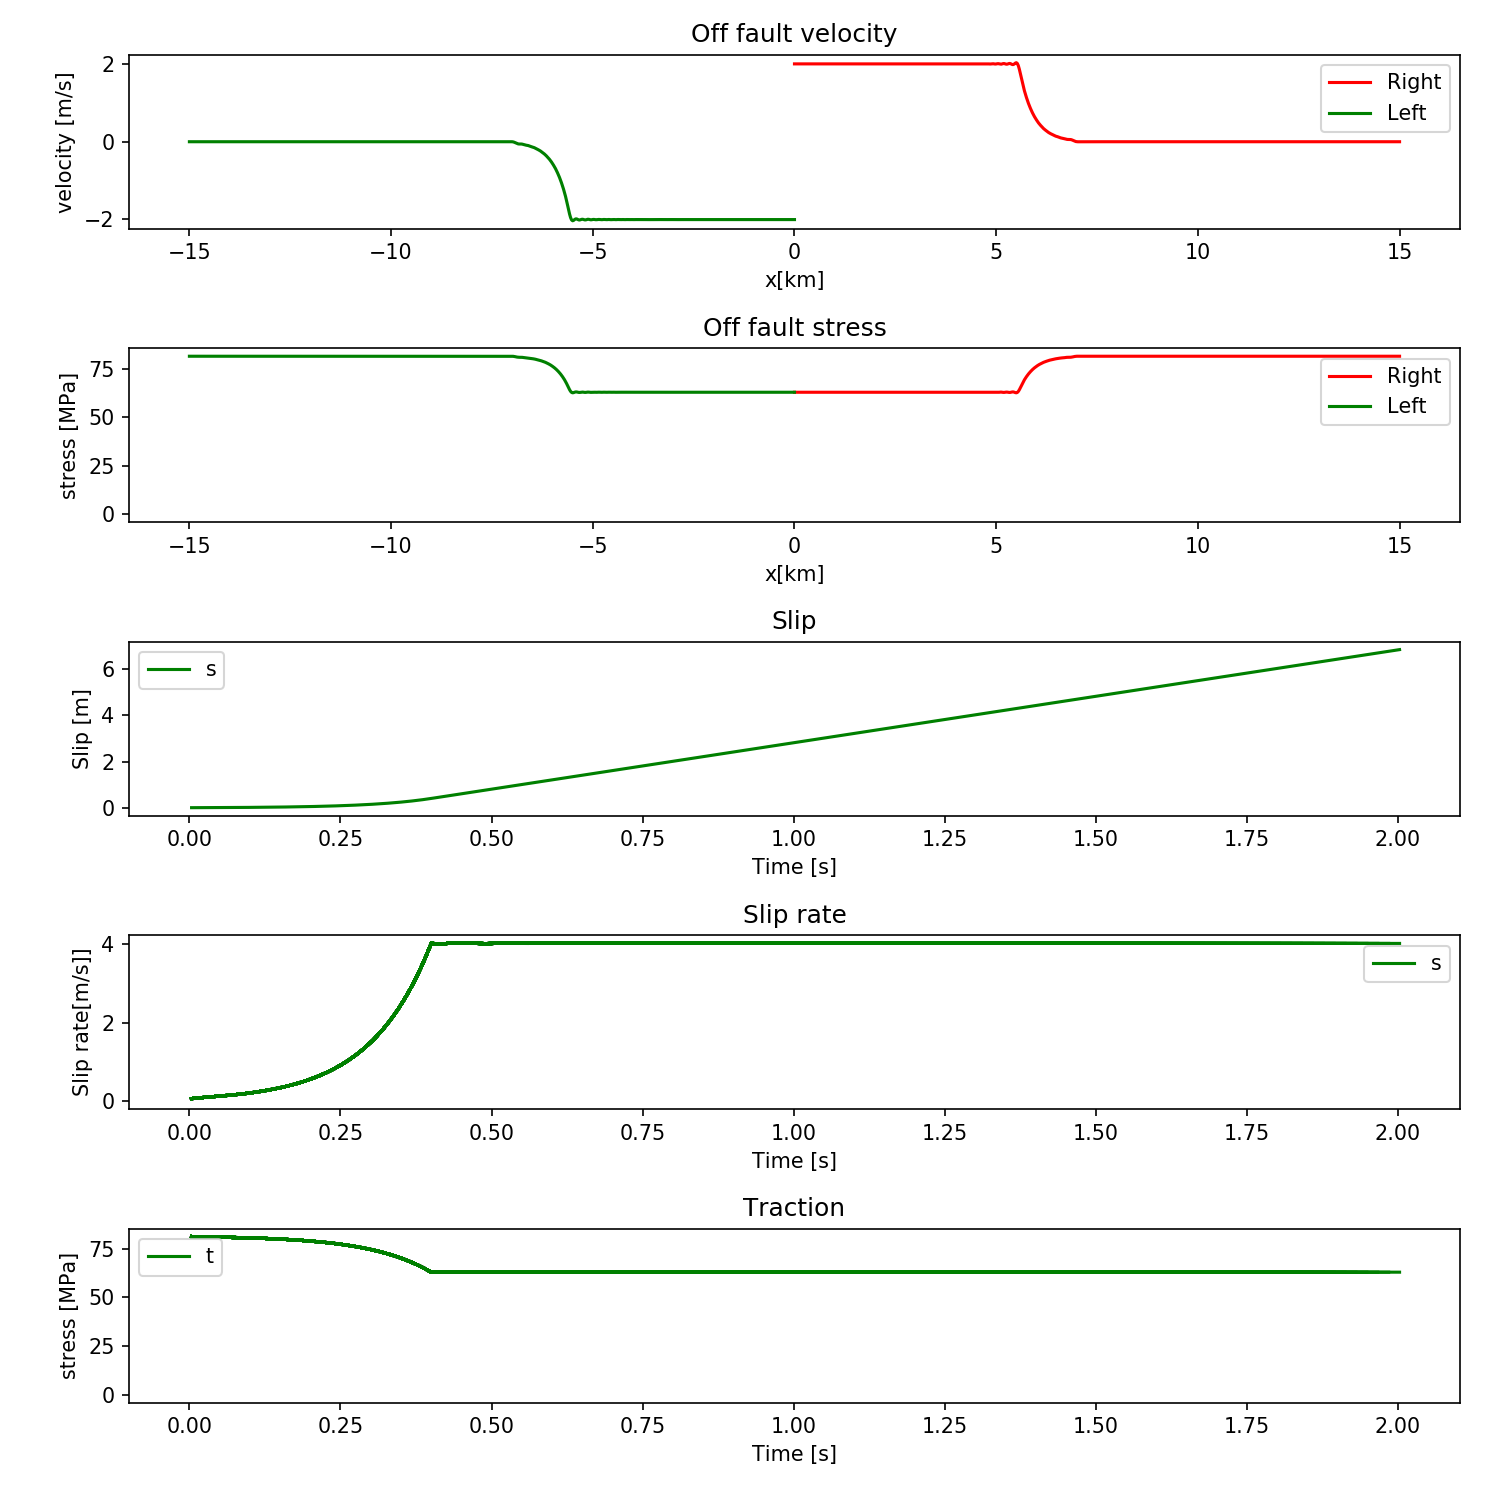

total simulation time =  93.67329373542502
spatial order  of accuracy =  6
number of grid points =  601


In [4]:
# Calculations and plottings for on fault slip velocity and stress


# Initialize animated plot for velocity and stress
fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(5,1,1)
line1 = ax1.plot(y_l, v_l, 'r', y_r, v_r, 'g')
plt.title('Off fault velocity')
plt.xlabel('x[km]')
plt.ylabel('velocity [m/s]')

ax2 = fig1.add_subplot(5,1,2)
line2 = ax2.plot(y_l, s_l, 'r', y_r, s_r, 'g')
plt.title('Off fault stress')
plt.xlabel('x[km]')
plt.ylabel('stress [MPa]')

ax3 = fig1.add_subplot(5,1,3)
line3 = ax3.plot(0,0,'g')
plt.title('Slip')
plt.xlabel('Time [s]')
plt.ylabel('Slip [m]')

ax4 = fig1.add_subplot(5,1,4)
line4 = ax4.plot(0,0,'g')
plt.title('Slip rate')
plt.xlabel('Time [s]')
plt.ylabel('Slip rate[m/s]]')

ax5 = fig1.add_subplot(5,1,5)
line5 = ax5.plot(0,0,'g')
plt.title('Traction')
plt.xlabel('Time [s]')
plt.ylabel('stress [MPa]')

plt.tight_layout()
plt.ion()
plt.show()

# Loop through time and evolve the wave-fields using ADER time-stepping scheme of N+1 order of accuracy
start = timeit.default_timer()

n = 0                             # counter
for t in utils.drange (0.0, tend+dt,dt):
    n = n+1
    
    # compute numerical solution 
    time_integrator.elastic_RK4(v_l, s_l, v_l, s_l, rho_l, mu_l, nx, dx, order, y_l, t, dt, r0_l, r1_l,  tau_11_l,\
                    tau_21_l, tau_12_l, tau_22_l,v_r, s_r, v_r, s_r, rho_r, mu_r, nx, dx, order,\
                                y_r, t, dt, r0_r, r1_r,  tau_11_r, tau_21_r, tau_12_r, tau_22_r,\
                               slip, psi, slip, psi,friction_parameters)
    
    # appending slip, slip rate, traction, and time vector through each time step.
    traction_vector.append(Tau_0+s_l[-1,0])
    slip_vector.append(slip[0,0])
    time_vector.append(n*dt)
    sliprate_vector.append(np.abs(v_r[0,0]-v_l[-1,0]))
    
    # Updating plots
    if n % iplot == 0: 
        for l in line1:
            l.remove()
            del l               
        for l in line2:
            l.remove()
            del l
        for l in line3:
            l.remove()
            del l

        # Display lines
        line1 = ax1.plot(y_r, v_r, 'r',y_l, v_l, 'g')
        ax1.legend(iter(line1),('Right', 'Left'))
        line2 = ax2.plot(y_r, s_r+Tau_0, 'r',y_l, s_l+Tau_0, 'g')
        ax2.legend(iter(line2),('Right', 'Left'))
        line3 = ax3.plot(time_vector,slip_vector,'g')
        ax3.legend(iter(line3),('slip'))
        line4 = ax4.plot(time_vector,sliprate_vector,'g')
        ax4.legend(iter(line4),('slip rate'))
        line5 = ax5.plot(time_vector,traction_vector,'g')
        ax5.legend(iter(line5),('traction'))
        plt.gcf().canvas.draw()
                   
    
plt.ioff()
plt.show()
# Simulation end time
stop = timeit.default_timer()
print('total simulation time = ', stop - start)                   # print the time required for simulation
print('spatial order  of accuracy = ', order)                     # print the polynomial degree used
print('number of grid points = ', nx)                             # print the degree of freedom